<a href="https://colab.research.google.com/github/malcolmlett/ml-learning/blob/main/Learning_visualisations_v18_oscillations.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

Ideas to try:
* LR just on edge of being too high
  -> use PCA plot
* Ravine problem
* Small batch training
* Inbalanced dataset

In [24]:
# Install Training Instrumentation Toolkit
# (locked to specific git revision so this notebook always works)
import os
import sys
if not os.path.isdir('training-instrumentation-toolkit'):
  !git clone https://github.com/malcolmlett/training-instrumentation-toolkit.git
  !cd training-instrumentation-toolkit && git checkout 28c09cf
sys.path.append('training-instrumentation-toolkit')

# Imports
import train_instrumentation as tinstr
import train_explainer as texpl
import tensorflow as tf
from tensorflow.keras import layers
import numpy as np
import random
import matplotlib.pyplot as plt
import matplotlib.patches as patches
import matplotlib.transforms as transforms
import matplotlib.ticker as mticker
import sklearn
import scipy

# Prefer consistent behaviour
tf.config.experimental.enable_op_determinism()

Cloning into 'training-instrumentation-toolkit'...
remote: Enumerating objects: 1406, done.
remote: Counting objects: 100% (167/167), done.
remote: Compressing objects: 100% (139/139), done.
remote: Total 1406 (delta 92), reused 58 (delta 26), pack-reused 1239 (from 1)
Receiving objects: 100% (1406/1406), 112.67 MiB | 21.66 MiB/s, done.
Resolving deltas: 100% (841/841), done.
Note: switching to '28c09cf'.

You are in 'detached HEAD' state. You can look around, make experimental
changes and commit them, and you can discard any commits you make in this
state without impacting any branches by switching back to a branch.

If you want to create a new branch to retain commits you create, you may
do so (now or later) by using -c with the switch command. Example:

  git switch -c <new-branch-name>

Or undo this operation with:

  git switch -

Turn off this advice by setting config variable advice.detachedHead to false

HEAD is now at 28c09cf Simplifying effort required to identify main weight

## Visualisation Tools
We'll make sure of a few different visualisations tools here to compare and contrast their effectiveness:
* Loss curves
* Gradient stats
* Epoch-to-epoch gradient correlations
* PCA of weight trajectory

Before getting started, setup the visualisations tools.

## Gradient correlations
The following paper visualises the Pearson correlation of the gradients from epoch-to-epoch.

Morchdi, C., Zhou, Y., Ding, J., & Wang, B. (2023). Exploring Gradient Oscillation in Deep Neural Network Training. 59th Annual Allerton Conference on Communication, Control, and Computing (Allerton, USA).
* https://www.sci.utah.edu/~beiwang/publications/Mysterious_BeiWang_2023.pdf


In [49]:
def plot_correlation_trends(gradients_cb, title="Correlation Between Consecutive Training Epochs", xlabel="epoch"):
  """Works against per-epoch and per-step data, although in practice the results are pretty meaningless when plotting against per-step data"""

  # validate
  if gradients_cb.gradients is None:
    raise ValueError("Cannot plot - raw gradients were not collected")

  # prepare
  # - identify which variables we're plotting for
  variable_index_by_layer = tinstr.variable_indices_by_layer(gradients_cb.model, single=True)
  variable_indices = [var_idx for var_idx in variable_index_by_layer if var_idx is not None]
  layer_indices = [l_idx for l_idx, var_idx in enumerate(variable_index_by_layer) if var_idx is not None]
  chart_names = [f"layer {l_idx}:\n{model.variables[var_idx].path}" for var_idx, l_idx in zip(variable_indices, layer_indices)]
  num_layers = len(layer_indices)

  # start figure
  # - at most 4 wide
  grid_width = 4
  grid_height = int(np.ceil(num_layers / grid_width))
  plt.figure(figsize=(15, grid_height * 3), layout='constrained')

  # chart per variable
  for i, var_idx in enumerate(variable_indices):
    # compute correlation between consecutive iterations
    data = np.stack(gradients_cb.gradients[var_idx], axis=0)  # shape: (iterations, spatial-dims...)
    data = data.reshape(data.shape[0], -1)  # shape: (iterations, spatial-size), where spatial-size = scalar flattened size
    iterations = data.shape[0]  # Number of epochs (or steps)
    correlations = [scipy.stats.pearsonr(data[i-1], data[i])[0] for i in range(1, iterations)]
    correlations = np.array(correlations)

    # Do chart
    plt.subplot(grid_height, grid_width, i + 1)
    plt.title(chart_names[i])
    plt.plot(range(1, iterations), correlations)
    plt.xlabel(xlabel)
    plt.ylabel("correlation (ep-1 → ep)")
    plt.margins(0)
    plt.ylim([-1.1, 1.1])
    plt.gca().xaxis.set_major_locator(mticker.MaxNLocator(integer=True))  # ensure integer x-axis ticks
  plt.show()

## Learning Rate Issues
Sometimes the learning rate is too large, but only by a small margin. In these cases it can cause oscillations that are too small to see at the per-epoch level.

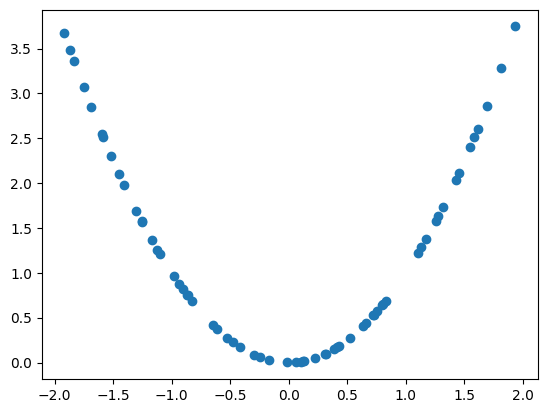

In [4]:
def polynomial_dataset():
  x = np.linspace(start=-2, stop=2, num=64*500)
  y = x**2
  dataset = tf.data.Dataset.from_tensor_slices((x, y))
  dataset = dataset.shuffle(buffer_size=dataset.cardinality(), seed=1, reshuffle_each_iteration=True).batch(64)
  return dataset

batch = next(iter(polynomial_dataset()))
plt.scatter(batch[0], batch[1])
plt.show()

In [5]:
def regression_model():
    input = tf.keras.Input(shape=(1,), name="input")
    x = layers.Dense(5, activation='tanh', name='dense1')(input)
    x = layers.Dense(5, activation='tanh', name='dense2')(x)
    x = layers.Dense(1, activation='linear', name='dense3')(x)
    return tf.keras.Model(input, x)

# uncomment to see summary
regression_model().summary()

Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ input (InputLayer)                   │ (None, 1)                   │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense1 (Dense)                       │ (None, 5)                   │              10 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense2 (Dense)                       │ (None, 5)                   │              30 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense3 (Dense)                       │ (None, 1)                   │               6 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 46 (184.00 B)

 Trainable params: 46 (184.00 B)

 Non-trainable params: 0 (0.00 B)

**Experiment:**
* First, let's look at an example of a learning rate that's been optimized fast convergence without causing oscillations.

In [60]:
tf.keras.utils.set_random_seed(1)

gradients = tinstr.GradientHistoryCallback(collection_sets=[{}])
step_variables = tinstr.VariableHistoryCallback(per_step=True, activity_stats=False)
step_gradients = tinstr.GradientHistoryCallback(per_step=True, activity_stats=False)

model = regression_model()
model.compile(optimizer=tf.keras.optimizers.SGD(learning_rate=1e-2), loss='mse')
dataset = polynomial_dataset()
history = tinstr.fit(model, dataset, epochs=20, verbose=0, callbacks=[tinstr.LessVerboseProgressLogger(), tinstr.HistoryStats(per_step=True), gradients, step_variables, step_gradients])

Epoch     2 - 6.61s/epoch: loss: 0.0537  
Epoch     4 - 7.57s/epoch: loss: 0.0079  
Epoch     6 - 5.26s/epoch: loss: 0.0053  
Epoch     8 - 5.20s/epoch: loss: 0.0041  
Epoch    10 - 7.68s/epoch: loss: 0.0034  
Epoch    12 - 5.48s/epoch: loss: 0.0029  
Epoch    14 - 5.27s/epoch: loss: 0.0025  
Epoch    16 - 5.06s/epoch: loss: 0.0022  
Epoch    18 - 7.84s/epoch: loss: 0.0019  
Epoch    20 - 5.32s/epoch: loss: 0.0017  
Total training time: 122.6 sec


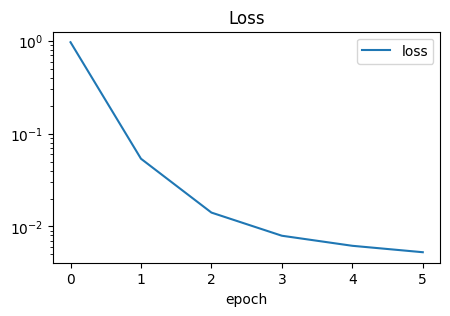

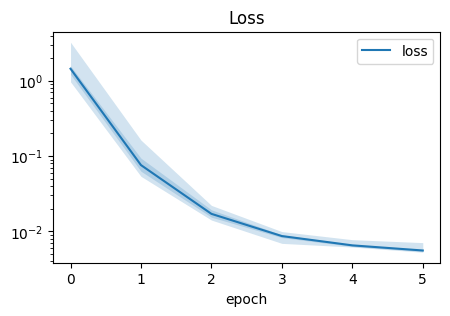

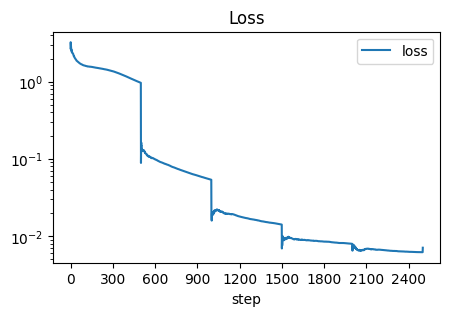

In [29]:
# plot just the first few epochs - with varying levels of detail
tinstr.plot_train_history(history, iterations=range(0,6), show_loss_percentiles=False)
tinstr.plot_train_history(history, iterations=range(0,6))
tinstr.plot_train_history(history, iterations=range(0,5*500+1), per_step=True)

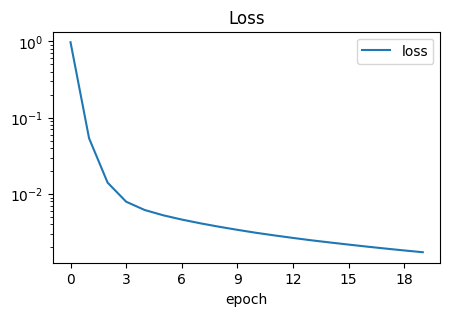

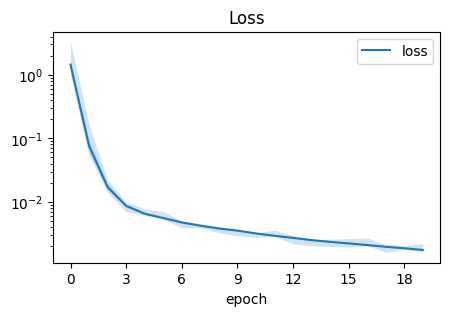

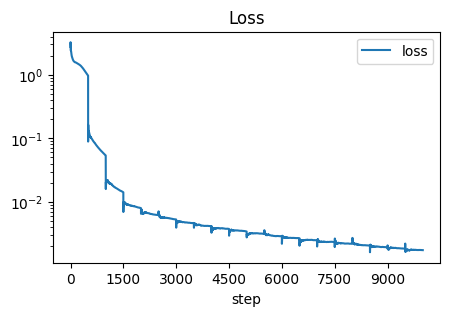

In [122]:
# plot with varying levels of detail
tinstr.plot_train_history(history, show_loss_percentiles=False)
tinstr.plot_train_history(history, show_loss_percentiles=True)
tinstr.plot_train_history(history, per_step=True)

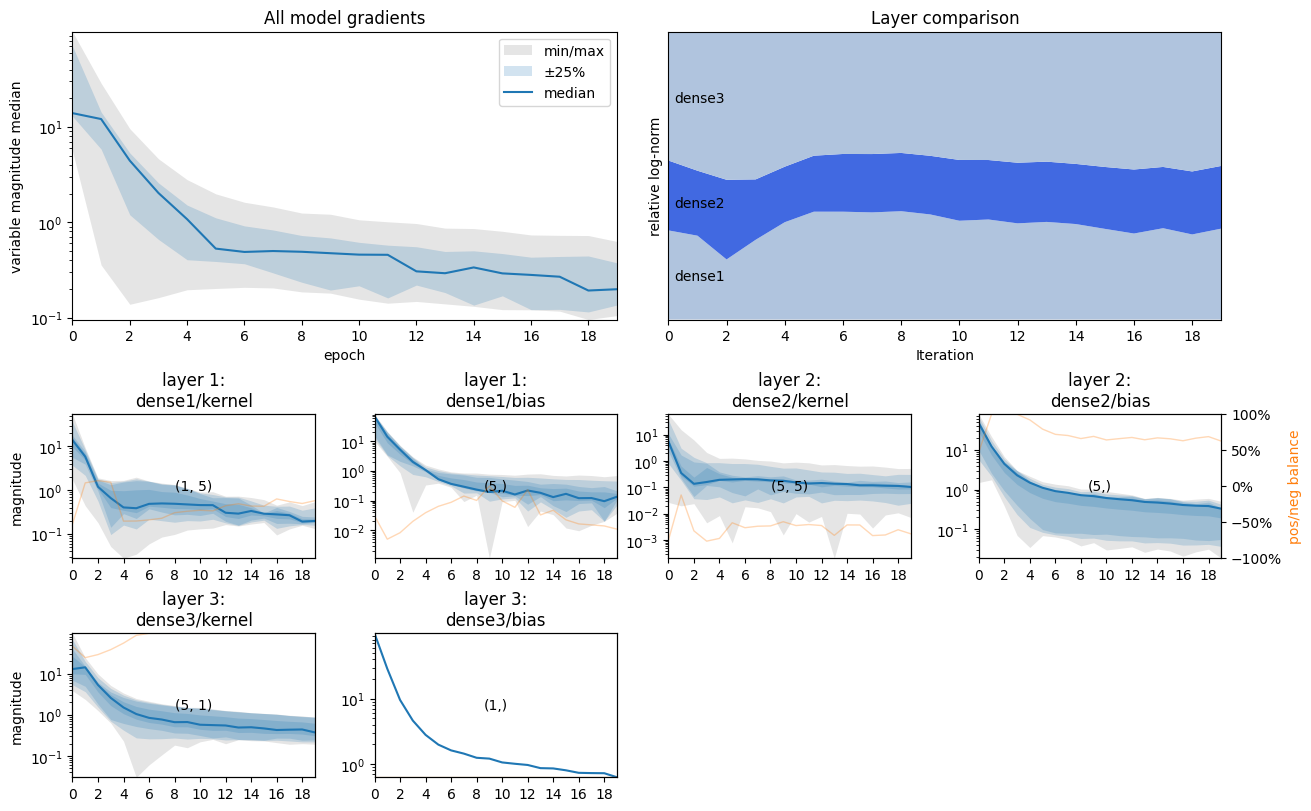

In [62]:
tinstr.plot_value_history(gradients)

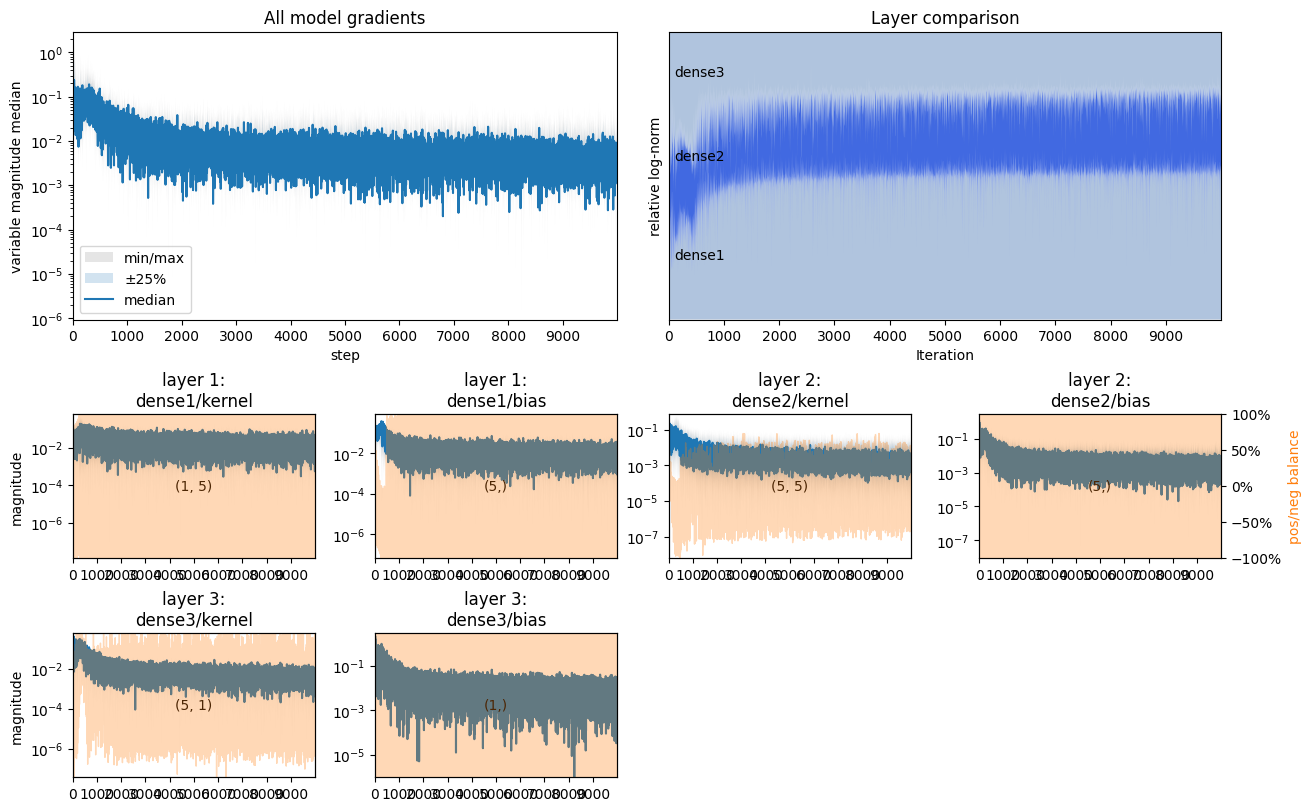

In [61]:
tinstr.plot_value_history(step_gradients)

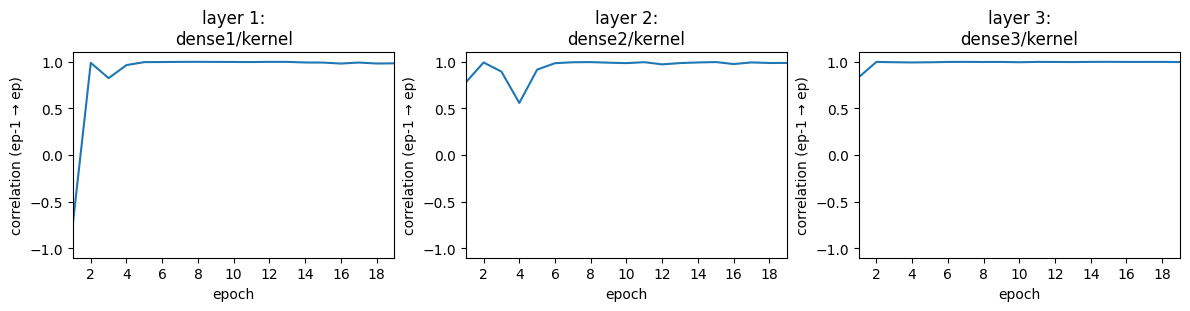

In [64]:
# note: gradients are summed over the course of the epoch
plot_correlation_trends(gradients)

**Commentary:**
* Notice that even with the percentile distribution of losses, the training curve still looks very smooth. The +/-25th and min/max extents are small relative to the scale of the loss and about equal in scale to the per-epoch change in loss.
* The small blips you see occur on the boundary between epochs and they seem to be almost impossible to eliminate, at least in TensorFlow. We're using SGD so there shouldn't be any momentum estimate effects that could get reset each epoch, and yet something appears to be getting affected in that way. I can't help but wonder if the optimizer takes smaller steps during each training step and then sums up a larger step at the end of the epoch after it's accumulated averages.

**Experiment:**
* Now we'll try with everything the same but with the learning rate just a little too high. Enough to cause oscillations that become obvious later on, but not immediately.

In [65]:
tf.keras.utils.set_random_seed(1)

gradients = tinstr.GradientHistoryCallback(collection_sets=[{}])
step_variables = tinstr.VariableHistoryCallback(per_step=True, activity_stats=False)
step_gradients = tinstr.GradientHistoryCallback(per_step=True, activity_stats=False)

model = regression_model()
model.compile(optimizer=tf.keras.optimizers.SGD(learning_rate=1e-1), loss='mse')
dataset = polynomial_dataset()
history = tinstr.fit(model, dataset, epochs=20, verbose=0, callbacks=[tinstr.LessVerboseProgressLogger(), tinstr.HistoryStats(per_step=True), gradients, step_variables, step_gradients])

Epoch     2 - 6.55s/epoch: loss: 0.0129  
Epoch     4 - 5.37s/epoch: loss: 0.0041  
Epoch     6 - 5.36s/epoch: loss: 0.0018  
Epoch     8 - 5.38s/epoch: loss: 0.0029  
Epoch    10 - 5.40s/epoch: loss: 0.0016  
Epoch    12 - 5.55s/epoch: loss: 0.0011  
Epoch    14 - 5.19s/epoch: loss: 0.0006  
Epoch    16 - 7.77s/epoch: loss: 0.0005  
Epoch    18 - 5.38s/epoch: loss: 0.0008  
Epoch    20 - 5.28s/epoch: loss: 0.0014  
Total training time: 114.5 sec


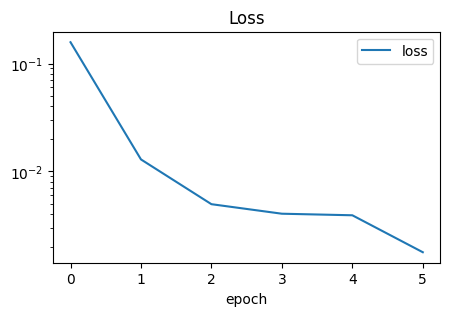

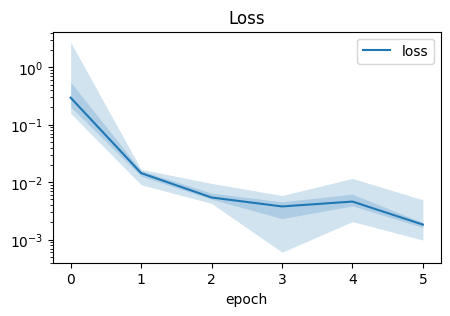

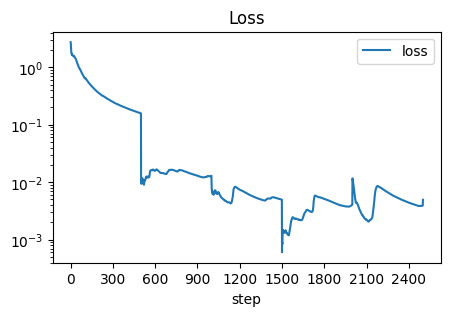

In [119]:
# plot just the first few epochs - with varying levels of detail
tinstr.plot_train_history(history, iterations=range(0,6), show_loss_percentiles=False)
tinstr.plot_train_history(history, iterations=range(0,6))
tinstr.plot_train_history(history, iterations=range(0,5*500+1), per_step=True)

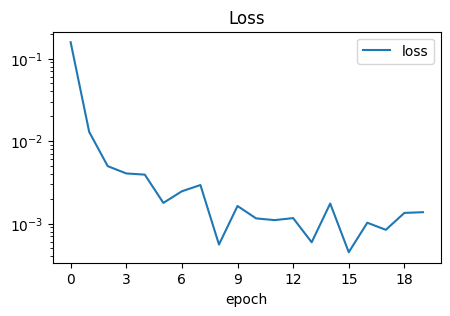

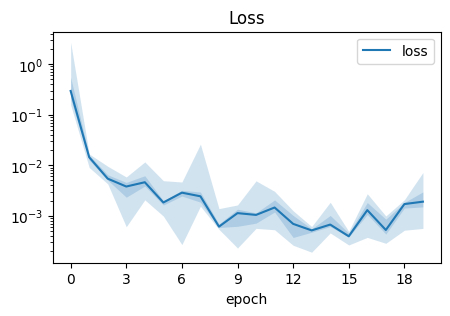

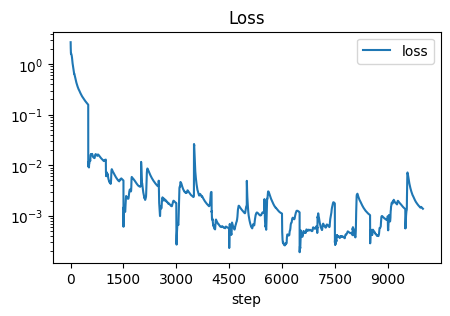

In [118]:
# plot with varying levels of detail
tinstr.plot_train_history(history, show_loss_percentiles=False)
tinstr.plot_train_history(history, show_loss_percentiles=True)
tinstr.plot_train_history(history, per_step=True)

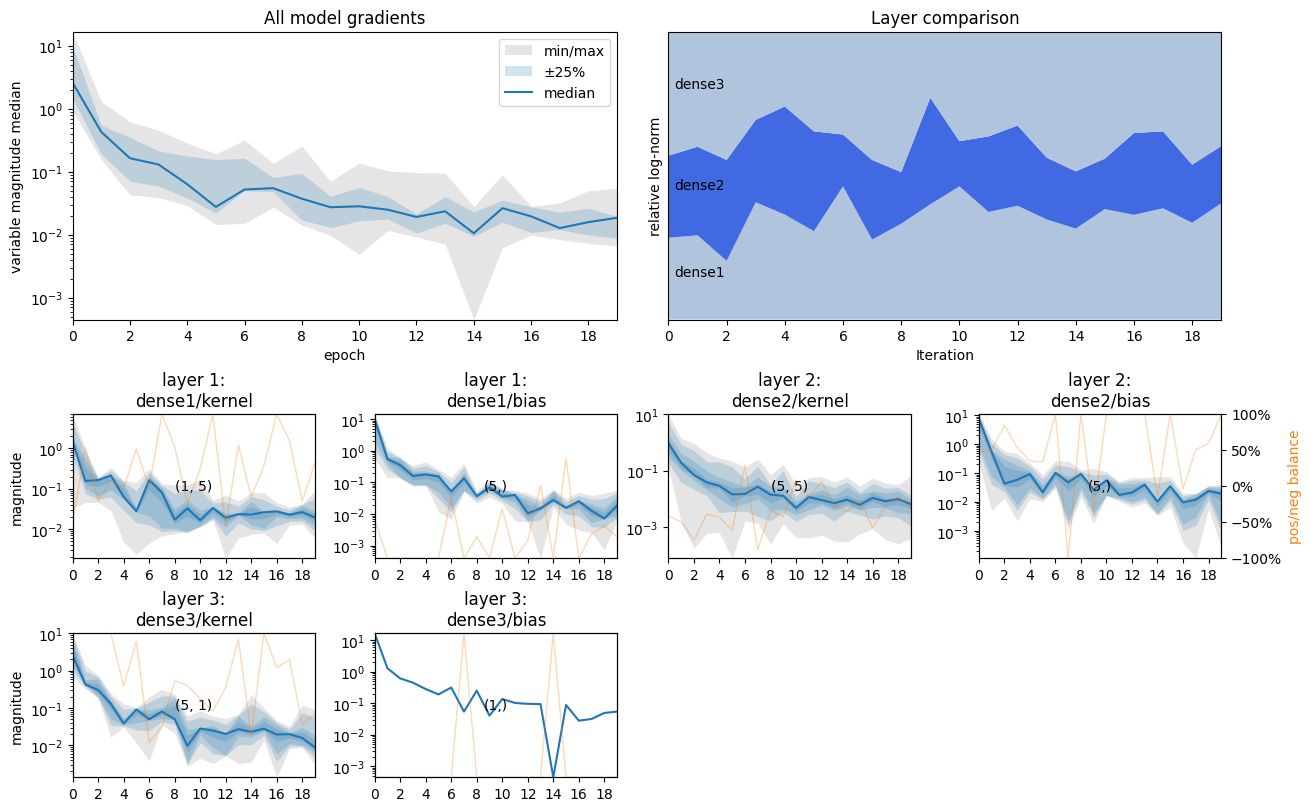

In [66]:
tinstr.plot_value_history(gradients)

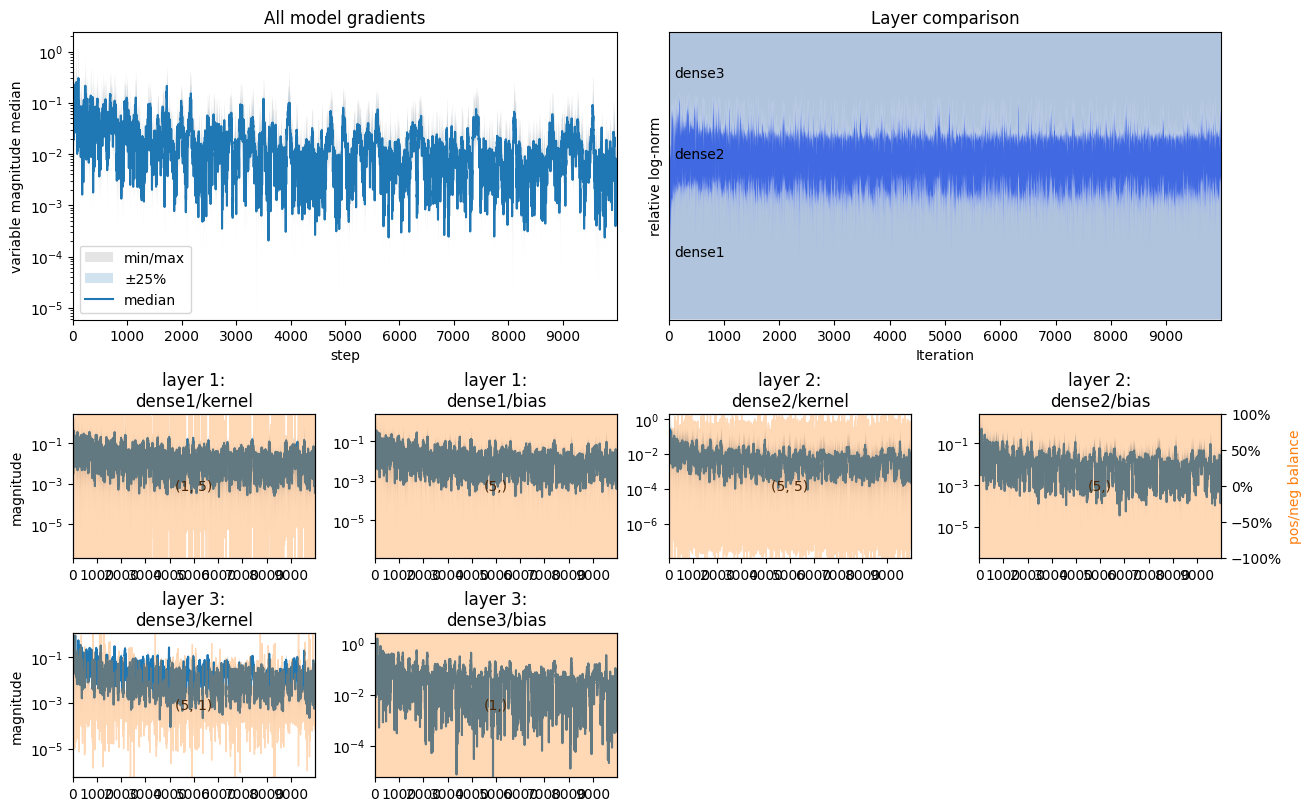

In [67]:
tinstr.plot_value_history(step_gradients)

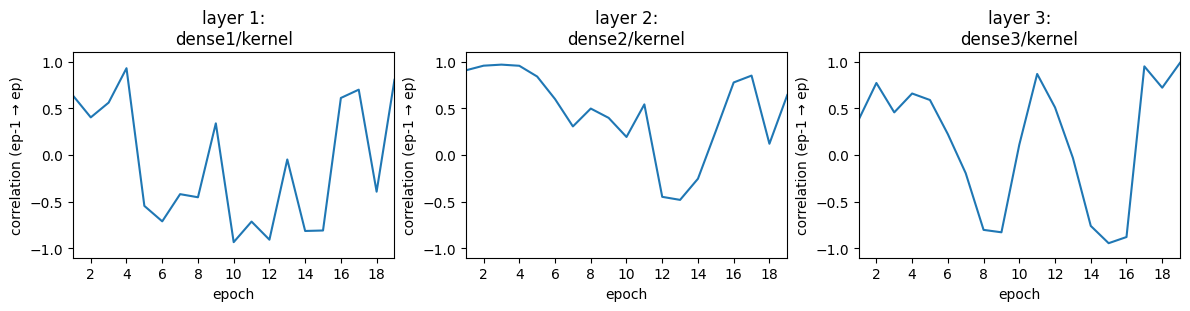

In [68]:
plot_correlation_trends(gradients)

**Commentary:**
* Notice that the first 6 epochs of the average-only loss curve shows almost no difference to the first result.
* And yet, when you look deeper, there is a clear difference between the two trainig curves.

**Experiment:**
* To contrast to an ideal learning curve, let's train a model that should significantly more easily model the $x^2$ function.

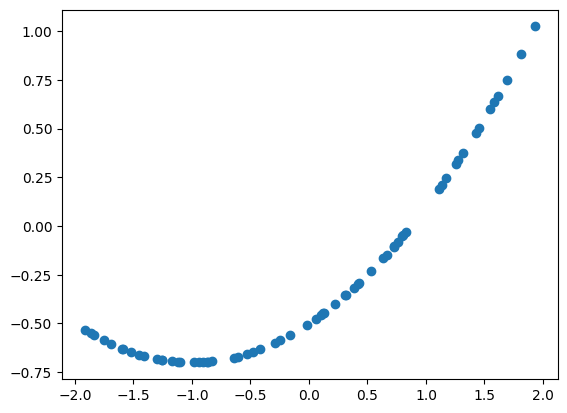

In [85]:
def polynomial2_dataset():
  x = np.linspace(start=-2, stop=2, num=64*500)
  y = 0.2*x**2 + 0.4*x - 0.5
  dataset = tf.data.Dataset.from_tensor_slices((x, y))
  dataset = dataset.shuffle(buffer_size=dataset.cardinality(), seed=1, reshuffle_each_iteration=True).batch(64)
  return dataset

batch = next(iter(polynomial2_dataset()))
plt.scatter(batch[0], batch[1])
plt.show()

In [86]:
def polynomial_model():
    input = tf.keras.Input(shape=(1,), name="input")
    x1 = input
    x2 = layers.Multiply(name='multiply1')([input, input])
    x = layers.Concatenate(name='concat1')([x1, x2])
    x = layers.Dense(1, activation='linear', name='dense1')(x)
    return tf.keras.Model(input, x)

# uncomment to see summary
polynomial_model().summary()

Model: "functional_24"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)              ┃ Output Shape           ┃        Param # ┃ Connected to           ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━┩
│ input (InputLayer)        │ (None, 1)              │              0 │ -                      │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ multiply1 (Multiply)      │ (None, 1)              │              0 │ input[0][0],           │
│                           │                        │                │ input[0][0]            │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ concat1 (Concatenate)     │ (None, 2)              │              0 │ input[0][0],           │
│                           │                        │                │ multiply1[0][0]        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ dense1 (Dense)            │ (None, 1)              │              3 │ concat1[0][0]          │
└───────────────────────────┴────────────────────────┴────────────────┴────────────────────────┘

 Total params: 3 (12.00 B)

 Trainable params: 3 (12.00 B)

 Non-trainable params: 0 (0.00 B)

In [87]:
tf.keras.utils.set_random_seed(1)

gradients = tinstr.GradientHistoryCallback(collection_sets=[{}])
step_variables = tinstr.VariableHistoryCallback(per_step=True, activity_stats=False)
step_gradients = tinstr.GradientHistoryCallback(per_step=True, activity_stats=False)

model = polynomial_model()
model.compile(optimizer=tf.keras.optimizers.SGD(learning_rate=1e-2), loss='mse')
dataset = polynomial2_dataset()
history = tinstr.fit(model, dataset, epochs=20, verbose=0, callbacks=[tinstr.LessVerboseProgressLogger(), tinstr.HistoryStats(per_step=True), gradients, step_variables, step_gradients])

Epoch     2 - 3.72s/epoch: loss: 0.0000  
Epoch     4 - 3.03s/epoch: loss: 0.0000  
Epoch     6 - 3.34s/epoch: loss: 0.0000  
Epoch     8 - 3.04s/epoch: loss: 0.0000  
Epoch    10 - 4.08s/epoch: loss: 0.0000  
Epoch    12 - 3.32s/epoch: loss: 0.0000  
Epoch    14 - 3.03s/epoch: loss: 0.0000  
Epoch    16 - 4.05s/epoch: loss: 0.0000  
Epoch    18 - 4.86s/epoch: loss: 0.0000  
Epoch    20 - 3.27s/epoch: loss: 0.0000  
Total training time: 71.5 sec


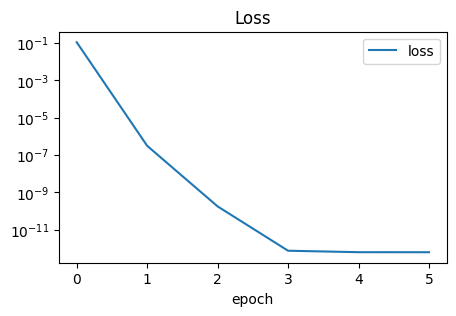

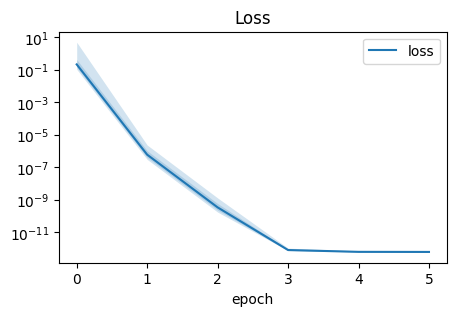

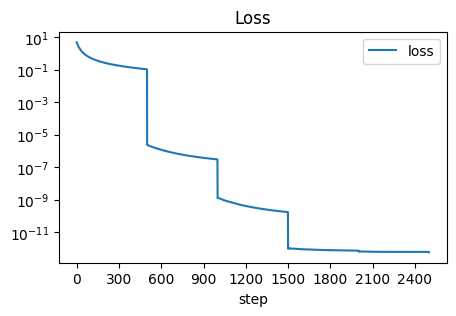

In [88]:
# plot just the first few epochs - with varying levels of detail
tinstr.plot_train_history(history, iterations=range(0,6), show_loss_percentiles=False)
tinstr.plot_train_history(history, iterations=range(0,6))
tinstr.plot_train_history(history, iterations=range(0,5*500+1), per_step=True)

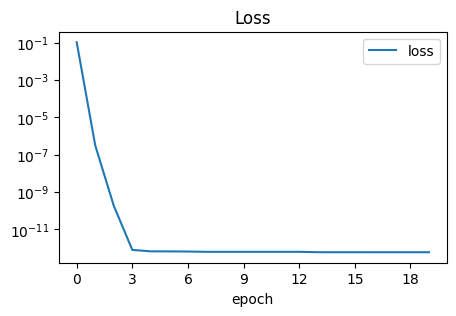

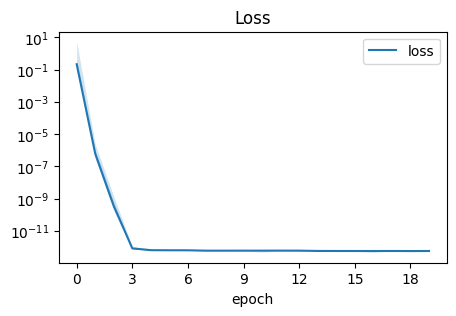

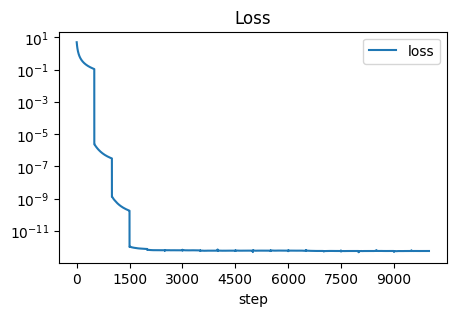

In [89]:
# plot with varying levels of detail
tinstr.plot_train_history(history, show_loss_percentiles=False)
tinstr.plot_train_history(history, show_loss_percentiles=True)
tinstr.plot_train_history(history, per_step=True)

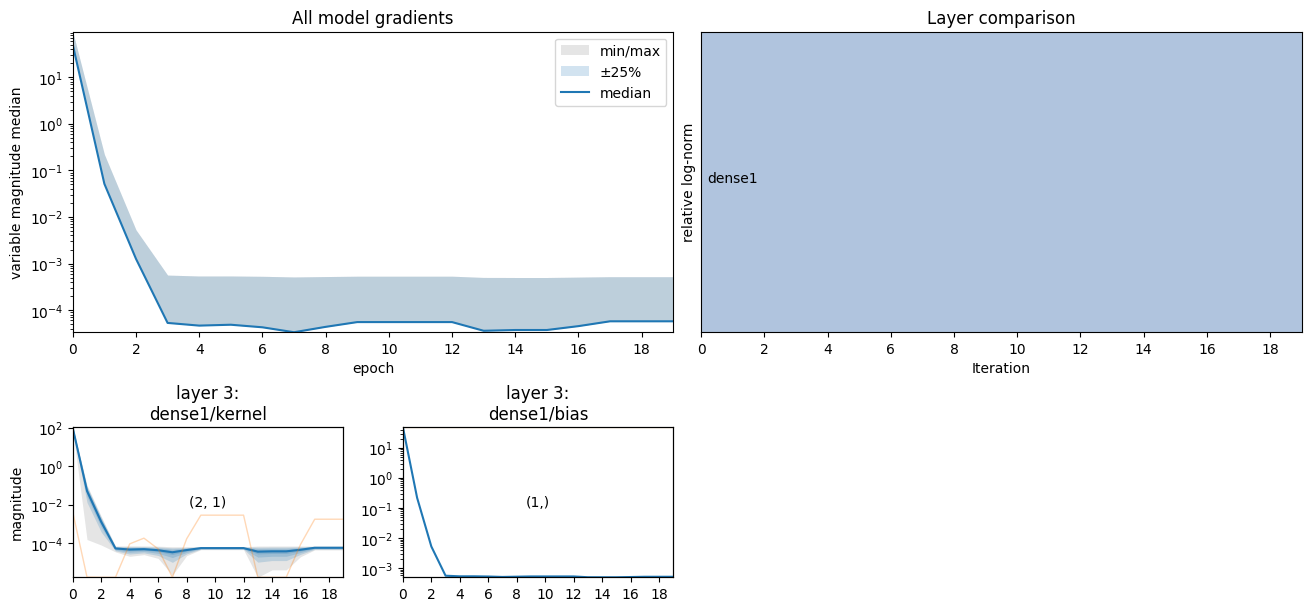

In [90]:
tinstr.plot_value_history(gradients)

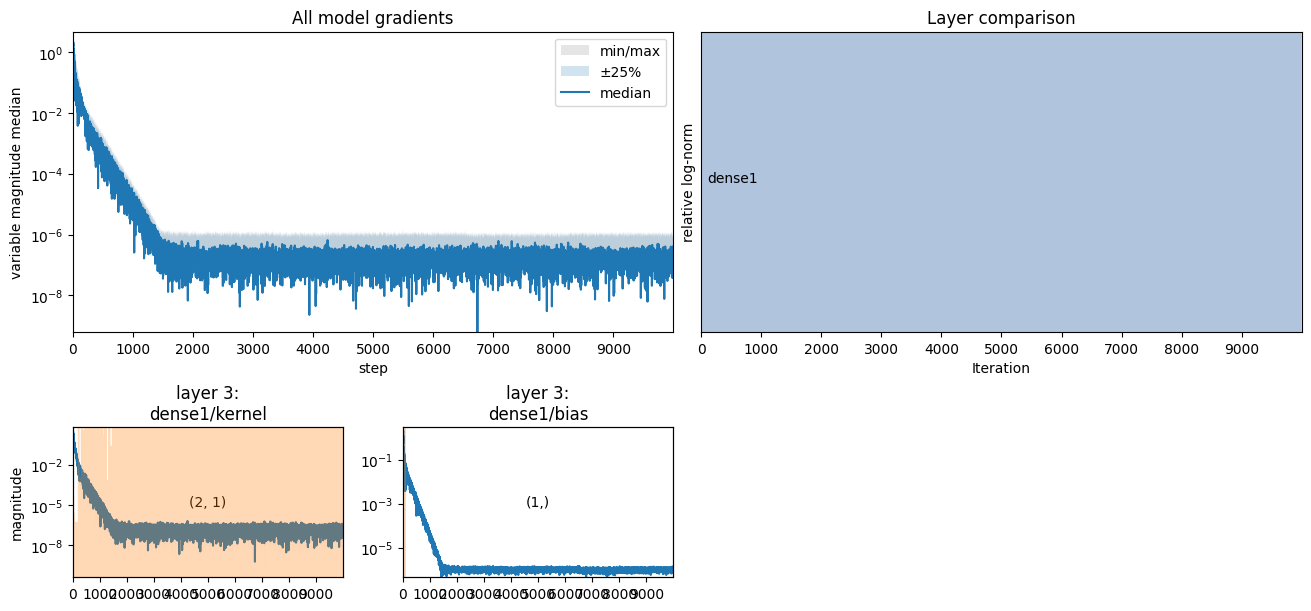

In [91]:
tinstr.plot_value_history(step_gradients)

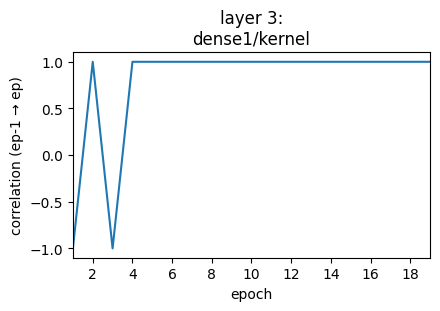

In [92]:
plot_correlation_trends(gradients)

## Oscillations due to Skewed Datasets

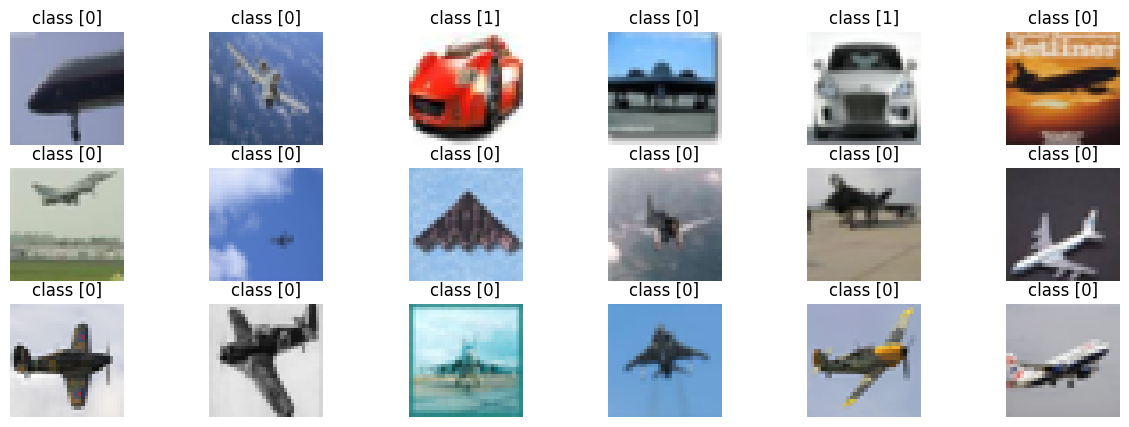

Unskewed:
  75 batches with Class 0: 2400 entries, Class 1: 2400 entries
Skewed:
  75 batches with Class 0: 4367 entries, Class 1: 433 entries


In [92]:
# Load CIFAR-10 dataset
(x_train, y_train), _ = tf.keras.datasets.cifar10.load_data()
x_train = x_train.astype('float32') / 255.0

def cifar2_dataset(skewed=False):
  def filter(x, y):
    if y == 0:
      return True
    elif y == 1 and (not skewed or tf.random.uniform((1,))[0] < 0.1):
      # only include 10% of the time if skewed=True
      return True
    else:
      return False # skip all other classes

  tf.keras.utils.set_random_seed(1)
  dataset = tf.data.Dataset.from_tensor_slices((x_train, y_train))
  dataset = dataset.filter(filter).shuffle(buffer_size=1024, seed=1).batch(32)
  dataset = dataset.repeat().take(150) # avoid non-determinism in steps_per_epoch
  return dataset

def show_class_counts(dataset):
  cnt_0 = 0
  cnt_1 = 0
  cnt_b = 0
  for batch in dataset:
    y = batch[1]
    cnt_0 += tf.math.count_nonzero(y == 0).numpy()
    cnt_1 += tf.math.count_nonzero(y == 1).numpy()
    cnt_b += 1
  print(f"  {cnt_b} batches with Class 0: {cnt_0} entries, Class 1: {cnt_1} entries")

# Plot some examples
batch = next(iter(cifar2_dataset(skewed=True)))
plt.figure(figsize=(15,5))
for i in range(18):
    x, y = batch[0][i], batch[1][i]
    plt.subplot(3, 6, i + 1)
    plt.title(f"class {y}")
    plt.imshow(x)
    plt.axis('off')
plt.show()

print(f"Unskewed:")
show_class_counts(cifar2_dataset(skewed=False))
print(f"Skewed:")
show_class_counts(cifar2_dataset(skewed=True))

In [100]:
def classification_model():
    image_input = tf.keras.Input(shape=(32, 32, 3), name="image_input")

    # convolutional layers
    # - 32x32x3 -> 16x16x8 -> 8x8x16 -> 4x4x32 -> 2x2x64
    conv = layers.Conv2D(filters=8, kernel_size=3, activation='relu', padding='same', name='conv2d_1a')(image_input)
    conv = layers.Conv2D(filters=8, kernel_size=3, activation='relu', padding='same', name='conv2d_1b')(conv)
    conv = layers.MaxPooling2D(pool_size=2, name='pool2d_1')(conv)
    conv = layers.Conv2D(filters=16, kernel_size=3, activation='relu', padding='same', name='conv2d_2a')(conv)
    conv = layers.Conv2D(filters=16, kernel_size=3, activation='relu', padding='same', name='conv2d_2b')(conv)
    conv = layers.MaxPooling2D(pool_size=2, name='pool2d_2')(conv)
    conv = layers.Conv2D(filters=32, kernel_size=3, activation='relu', padding='same', name='conv2d_3a')(conv)
    conv = layers.Conv2D(filters=32, kernel_size=3, activation='relu', padding='same', name='conv2d_3b')(conv)
    conv = layers.MaxPooling2D(pool_size=2, name='pool2d_3')(conv)
    conv = layers.Conv2D(filters=64, kernel_size=3, activation='relu', padding='same', name='conv2d_4a')(conv)
    conv = layers.Conv2D(filters=64, kernel_size=3, activation='relu', padding='same', name='conv2d_4b')(conv)
    conv = layers.MaxPooling2D(pool_size=2, name='pool2d_4')(conv)

    # dense layers
    # - 2x2x64 -> 256 -> 128 -> 10
    out = layers.Flatten(name='x1_flatten')(conv)
    out = layers.Dense(128, activation='relu', name='x1_dense_1')(out)
    out = layers.Dense(128, activation='relu', name='head_dense1')(out)
    out = layers.Dense(128, activation='relu', name='head_dense2')(out)
    out = layers.Dense(10, activation='linear', name='head_dense3')(out)  # logits output

    return tf.keras.Model(inputs=image_input, outputs=out)

# Uncomment to print model summary
#classification_model().summary()

In [96]:
# unskewed
tf.keras.utils.set_random_seed(1)
model = classification_model()
model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=1e-3), loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True))
dataset = cifar2_dataset(skewed=False)
history = tinstr.fit(model, dataset, epochs=50, verbose=0, callbacks=[tinstr.LessVerboseProgressLogger(), tinstr.HistoryStats(per_step=True)])

Epoch     5 - 2.37s/epoch: loss: 0.3353  
Epoch    10 - 1.49s/epoch: loss: 0.1438  
Epoch    15 - 1.23s/epoch: loss: 0.0682  
Epoch    20 - 1.49s/epoch: loss: 0.0330  
Epoch    25 - 1.75s/epoch: loss: 0.0257  
Epoch    30 - 1.51s/epoch: loss: 0.0269  
Epoch    35 - 1.48s/epoch: loss: 0.0273  
Epoch    40 - 1.77s/epoch: loss: 0.0160  
Epoch    45 - 1.24s/epoch: loss: 0.0032  
Epoch    50 - 1.48s/epoch: loss: 0.0269  


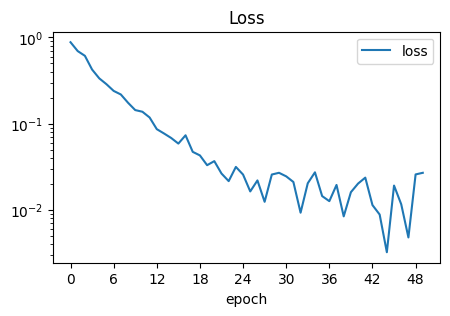

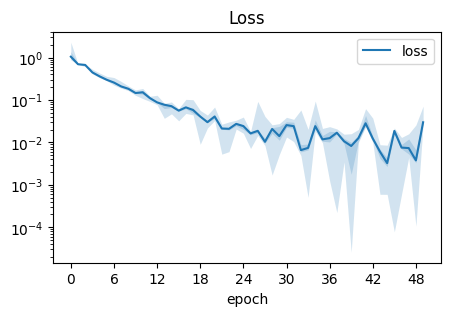

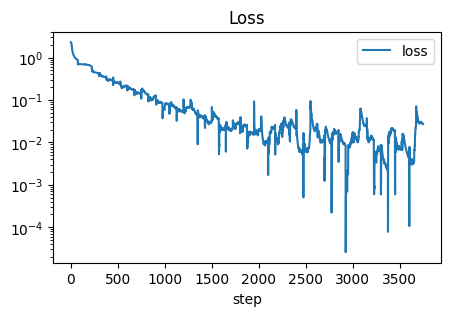

In [97]:
# plot with varying levels of detail
tinstr.plot_train_history(history, show_loss_percentiles=False)
tinstr.plot_train_history(history, show_loss_percentiles=True)
tinstr.plot_train_history(history, per_step=True)

In [98]:
# skewed
tf.keras.utils.set_random_seed(1)
model = classification_model()
model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=1e-3), loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True))
dataset = cifar2_dataset(skewed=True)
history = tinstr.fit(model, dataset, epochs=50, verbose=0, callbacks=[tinstr.LessVerboseProgressLogger(), tinstr.HistoryStats(per_step=True)])

Epoch     5 - 3.93s/epoch: loss: 0.1830  
Epoch    10 - 2.14s/epoch: loss: 0.1037  
Epoch    15 - 2.07s/epoch: loss: 0.0557  
Epoch    20 - 2.16s/epoch: loss: 0.0368  
Epoch    25 - 2.14s/epoch: loss: 0.0236  
Epoch    30 - 2.17s/epoch: loss: 0.0204  
Epoch    35 - 2.73s/epoch: loss: 0.0192  
Epoch    40 - 2.27s/epoch: loss: 0.0263  
Epoch    45 - 2.17s/epoch: loss: 0.0017  
Epoch    50 - 2.14s/epoch: loss: 0.0108  


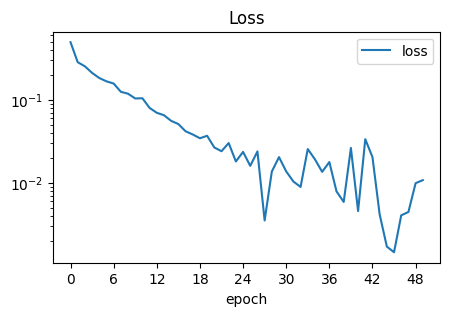

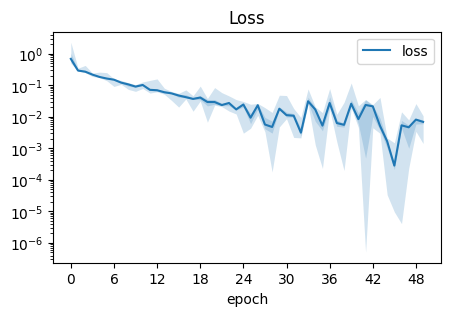

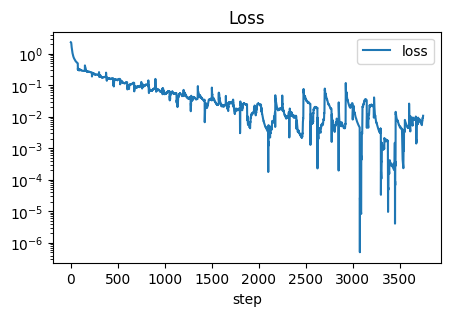

In [99]:
tinstr.plot_train_history(history, show_loss_percentiles=False)
tinstr.plot_train_history(history, show_loss_percentiles=True)
tinstr.plot_train_history(history, per_step=True)